Imports

In [ ]:
from PIL import Image, ImageDraw
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import re

# Part 1: Dataset generation

Load retinal image

In [ ]:
# Opens a image in RGB mode
im = Image.open(r"20205_map.png")

# Size of the image in pixels (size of original image)
width, height = im.size

im_rgb = im.convert('RGB')
im_mean = np.mean(im_rgb, axis=(0,1))/255
im_std = np.std(im_rgb, axis=(0,1))/255

Generate cropped images

In [ ]:
# patch_size: is square
# stride: is the number of pixels to skip 
def crop_and_save(image, patch_size, stride, class_number, path):
    im_width, im_height = image.size
    height_patches = (im_height - patch_size) // stride + 1
    width_patches = (im_width - patch_size) // stride + 1
    path += "{}/20205_map_class{}_{}.png"

    count = 0
    for i in range(height_patches): # height
        for j in range(width_patches): # width
        # ((left, top), (right, bottom))
            im = image.crop((j * stride, i * stride, patch_size + j * stride, patch_size + i * stride))
            im.save(path.format(class_number, class_number, count))
            count += 1

In [ ]:
data_dir = '/home/darrenhsu/Color/data_2/'
patch_size = 100
stride = 10

# Class 0, left
class0_im = im.crop((0,0,500,1000))
crop_and_save(class0_im, patch_size, stride, 0, data_dir)
# Class 1, right
class1_im = im.crop((500,0,1000,1000))
crop_and_save(class1_im, patch_size, stride, 1, data_dir)

Custom PyTorch Dataloader that includes datafile paths

In [ ]:
#https://discuss.pytorch.org/t/dataloader-filenames-in-each-batch/4212/2
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

Load dataset and perform train test split

In [ ]:
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([#transforms.RandomRotation(30),  # data augmentations are great
                                       #transforms.RandomResizedCrop(224),  # but not in this case of map tiles
                                       #transforms.RandomHorizontalFlip(),
                                       transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(im_mean,im_std)
                                       #transforms.Normalize([0.485, 0.456, 0.406], # PyTorch recommends these but in this
                                       #                     [0.229, 0.224, 0.225]) # case I didn't get good results
                                       ])

    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(im_mean,im_std)
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                      ])

    train_data = ImageFolderWithPaths(datadir, transform=train_transforms)
    test_data = ImageFolderWithPaths(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

Build pretrained ResNet model

In [ ]:
# Load ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

# Remove last softmax layer for deep feature extraction
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.to(device)

In [ ]:
flat_data_arr=[] #input array
target_arr=[] #output array

Generate deepfeatures from ResNet model

In [ ]:
# Generate deep features from ResNet model by forward pass
def image_feature_loader(dataloader):
    for inputs, labels, _ in dataloader:
        logps = model.forward(inputs.to(device))
        for i in range(len(labels)):
            flat_data_arr.append(np.array(logps[:,:,0,0][i].cpu().detach()))
            target_arr.append(np.array(labels[i].cpu().detach()))


image_feature_loader(trainloader)
image_feature_loader(testloader)

In [ ]:
# Load data into dataframe and save 
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data) #dataframe
df['Target']=target

In [ ]:
# Save df to csv
df.to_csv('deepfeature_2class.csv', index=False)

In [ ]:
#Used to generate train and test files, which are attached in submission
from sklearn.model_selection import train_test_split

data = pd.read_csv("deepfeature_2class.csv")
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)
pd.concat([X_train, y_train], axis=1).to_csv("retina_data_train.csv")
pd.concat([X_test, y_test], axis=1).to_csv("retina_data_test.csv")

# Part 2: MEC Calculation 

Memory Equivalent Capacity as a Dictionary

In [ ]:
import pandas as pd
import math 

df = pd.read_csv("retina_data_train.csv")
thresholds = 0
df["feature_sum"] = df.iloc[:,:-1].sum(axis=1)
df = df.sort_values(by="feature_sum")
cls = 0
for label in df["Target"]:
  if label != cls:
    thresholds += 1
    cls = label

print("There are", thresholds, "thresholds in the dataset")
print("This translates to a dataset MEC of", math.log(thresholds, 2) * 2048, "bits")

There are 2952 thresholds in the dataset
This translates to a dataset MEC of 23608.27290841169 bits


### Capacity Plot 

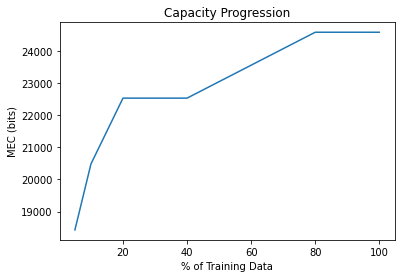

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot([5,10,20,40,80,100], np.asarray([9,10,11,11,12,12]) * 2048);
plt.title("Capacity Progression")
plt.xlabel("% of Training Data")
plt.ylabel("MEC (bits)");

### Training for memorization

In [ ]:
from sklearn.neural_network import MLPClassifier

data = pd.read_csv("retina_data_train.csv")
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
clf = MLPClassifier(
                hidden_layer_sizes=(12,), random_state=42,
                activation='relu')
clf.fit(X,y)
(clf.predict(X) == y).sum() / len(y)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.9921259842519685

### Training for generalization

In [ ]:
#KEEP
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

data = pd.read_csv("retina_data_train.csv")
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
train_accuracy_list = []
val_accuracy_list = []

for hidden_size in range(1,13):
  print("Now training + evaluating on hidden size", hidden_size)
  clf = MLPClassifier(hidden_layer_sizes=hidden_size, max_iter=500)
  clf.fit(X_train,y_train)
  train_accuracy_list.append((clf.predict(X_train) == y_train).sum() / len(y_train))
  val_accuracy_list.append((clf.predict(X_val) == y_val).sum() / len(y_val))

print(train_accuracy_list)
print(val_accuracy_list)

Now training + evaluating on hidden size 1
Now training + evaluating on hidden size 2
Now training + evaluating on hidden size 3
Now training + evaluating on hidden size 4
Now training + evaluating on hidden size 5
Now training + evaluating on hidden size 6
Now training + evaluating on hidden size 7
Now training + evaluating on hidden size 8
Now training + evaluating on hidden size 9
Now training + evaluating on hidden size 10
Now training + evaluating on hidden size 11
Now training + evaluating on hidden size 12
[0.49905759162303664, 0.5009424083769634, 0.956020942408377, 0.9566492146596859, 0.9627225130890052, 0.5009424083769634, 0.9673298429319371, 0.9522513089005236, 0.9421989528795811, 0.9470157068062828, 0.947434554973822, 0.9505759162303665]
[0.5150753768844221, 0.4849246231155779, 0.9271356783919598, 0.9279731993299832, 0.932998324958124, 0.4849246231155779, 0.9338358458961474, 0.9321608040201005, 0.9229480737018425, 0.9296482412060302, 0.9212730318257957, 0.9221105527638191]


Text(0.5, 1.0, 'Training for Generalization')

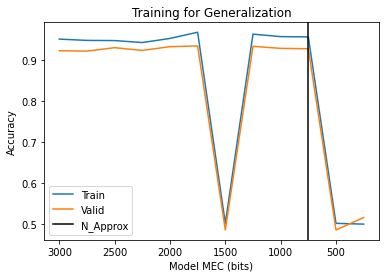

In [ ]:
graph, plot = plt.subplots()
plt.plot(list(range(250,250*13, 250)), train_accuracy_list, label="Train")
plt.plot(list(range(250,250*13, 250)), val_accuracy_list, label="Valid")
plt.axvline(x=3*250, color='black', label="N_Approx")
plt.legend()
plot.invert_xaxis()
plt.xlabel("Model MEC (bits)")
plt.ylabel("Accuracy")
plt.title("Training for Generalization")

In [ ]:
#KEEP
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

data = pd.read_csv("retina_data_train.csv")
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

clf = MLPClassifier(hidden_layer_sizes=(3,), max_iter=500)
clf.fit(X,y)
num_correct = (clf.predict(X) == y).sum()
acc = num_correct  / len(y)
print("The training accuracy after choosing the hidden layer size is", acc)
print("The generalization after choosing the hidden layer size is", num_correct / (2050*3))

The training accuracy after choosing the hidden layer size is 0.9484000670129
The generalization after choosing the hidden layer size is 0.9204878048780488


In [ ]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

train_data = pd.read_csv("retina_data_train.csv")
X_train = train_data.iloc[:,:-1]
y_train = train_data.iloc[:,-1]

clf = MLPClassifier(hidden_layer_sizes=(3,), max_iter=500)
clf.fit(X_train,y_train)

test_data = pd.read_csv("retina_data_test.csv")
X_test = test_data.iloc[:,:-1]
y_test = test_data.iloc[:,-1]

num_correct = (clf.predict(X_test) == y_test).sum()
acc = num_correct / len(y_test)
print("The test accuracy after choosing the hidden layer size is " + str(acc))

The test accuracy after choosing the hidden layer size is 0.941728064300067%
